# Desafio

A empresa Você Mais Seguro fornece planos de saúde e seguros de vida. 
A empresa está interessada em lança um novo seguro de veiculos, e desja entender a propensão de compra de seus clientes para este novo cenário. 
Em uma primeira etapa, foi realizada uma grande pesquisa com seus cleintes, para entender quais destes clientes estariam interessados em adquirir o novo seguro de veiculos.

Agora, com novos clientes do plano de saude entrando para sua base, a empresa deseja entender quais destes novos clientes teriam maior propensão de compra do novo seguro de veiculos.
No entanto, a empresa não esta interessada em gastar com pesquisas para todos os novos clientes, e sim apenas para aqueles que tem maior propensão de compra, 
haja visto,que seu efetivo comercial, não é capaz de entrar em contato, para fornecer um processo de pré vendas personalizado para toda a base de seus novos clientes, somente
para 2000 deles de cada vez. 

Para isso, este projeto tem como objetivo apresentar uma lista, com os 2000 clientes com maior probabilidade de venda do seguro de veículos.

# 0.0 Imports

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


### 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 8]
    plt.rcParams['font.size'] = 24
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

def print_descriptive_stats(df,
                            column):
    print(f'**Clientes que adquiririam o Seguro - {column} statistics**')
    print(df[df.Response == 1][column].describe())
    print('-'*45)
    print(f'**Clientes NAO que adquiririam o Seguro - {column} statistics**')
    print(df[df.Response == 0][column].describe())
    print('\n')

def get_frequency_table(df, column): 

    df_frequency_1 = df[df.Response == 1].groupby(column).Response.count().reset_index()
    df_frequency_1.rename(columns={'Response':'Count_Response_1'}, inplace=True)


    df_frequency_0 = df[df.Response == 0].groupby(column).Response.count().reset_index()
    df_frequency_0.rename(columns={'Response':'Count_Response_0'}, inplace=True)

    df_frequency = pd.merge(df_frequency_1, df_frequency_0, on=column, how='inner') 
    df_frequency['Total'] = df_frequency['Count_Response_1'] + df_frequency['Count_Response_0']
    df_frequency['Propensity_to_buy'] = df_frequency['Count_Response_1']/df_frequency['Total']
    df_frequency['%_sample_to_buy'] = df_frequency['Count_Response_1']/df_frequency['Count_Response_1'].sum() 
    df_frequency['%_sample_to_not_buy'] = df_frequency['Count_Response_0']/df_frequency['Count_Response_0'].sum() 
    df_frequency['%_sample_size']   = df_frequency['Total']/len(df)
    df_frequency['%_general_propensity_to_buy'] = len(df[df.Response==1])/len(df)
    
    return df_frequency

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1.0 Limpeza dos Dados

**Tipos de limpezas**

* Nulos
* Tipagem inconsistente 
* Claros outliers (indicio de erro de digitação)


### 1.1 - Conhecendo o Dataset

In [3]:
df_raw = pd.read_csv('../data/raw/data.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


**Features e NaN** 

In [4]:
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Não há NaN no dataset

----

**Descrevendo algumas features**

---- 

**Vintage:** - Tempo em dias, que o cliente esta na base da empresa.

**Policy Sales Channel** - Canal de contato com o cliente

**Vehicle_Damage:** - O Cliente ja teve algum dano em seu veiculo? 

**Previously Insured:** - O cliente já possuí algum seguro veicular?



### 1.2 - Validando os valores de cada coluna

Aqui o objetivo é compreender o valor presente em cada coluna, e se halguma coluna, não possuí algum valor de tipo inconsistente: 

**Exemplo:** idade possui valores do tipo string

In [5]:
cols_to_evaluate = df_raw.columns
cols_to_evaluate = cols_to_evaluate.drop(['id'])
cols_to_evaluate

for col in cols_to_evaluate:
    print('---'*20)
    print(col)
    print(df_raw[col].value_counts())

------------------------------------------------------------
Gender
Gender
Male      206089
Female    175020
Name: count, dtype: int64
------------------------------------------------------------
Age
Age
24    25960
23    24256
22    20964
25    20636
21    16457
26    13535
27    10760
28     8974
43     8437
44     8357
45     8183
42     8007
46     7879
41     7736
29     7429
47     7351
40     7168
48     7113
49     6615
39     6460
50     6263
30     6258
20     6232
51     5915
38     5710
52     5590
31     5512
37     5408
53     5331
36     5066
33     5010
32     4998
54     4997
35     4936
34     4895
55     4495
56     4063
57     3944
58     3822
59     3614
60     3534
61     3341
62     3104
63     3084
64     2850
65     2791
66     2725
67     2624
69     2530
68     2440
70     2349
71     2051
72     2035
73     1925
74     1832
75     1605
76     1396
77     1388
78     1216
79      915
80      909
81       56
82       29
83       22
84       11
85       11
Name

#### Conclusões

**Não foi identificada inconsistencia de tipagem**

Aqui não considerei a idade do veiculo (> 1 year...) como inconsistencia, uma vez que a ideia do campo, é realmente ser um campo do tipo texto.

### 1.3 - Identificando outliers claros que indicam falha no preenchimento dos dados

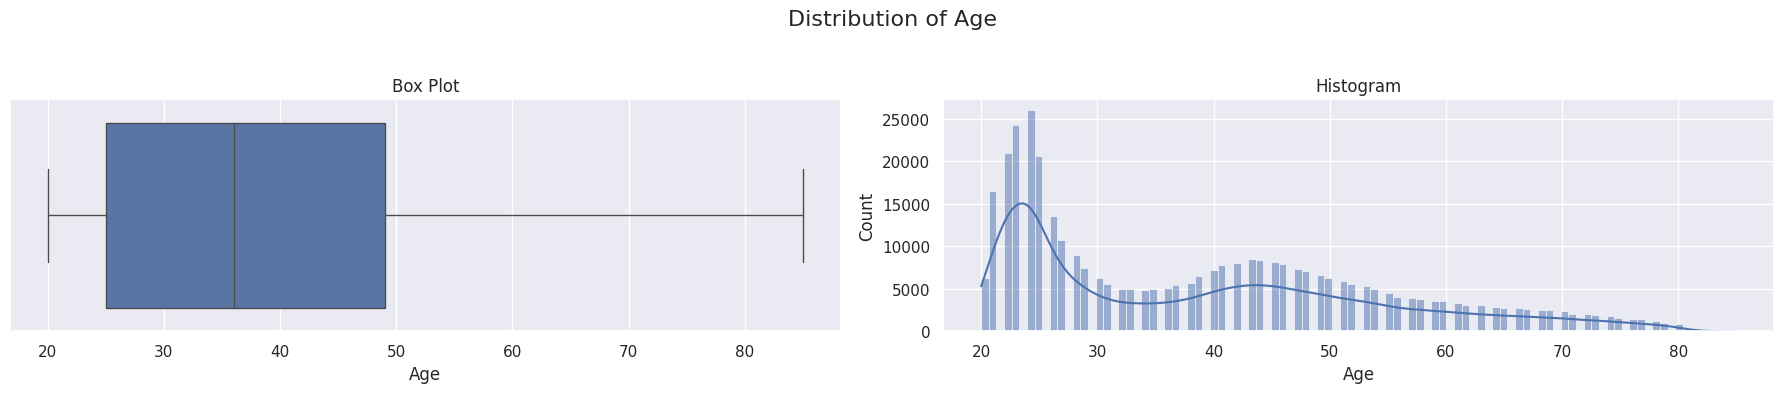

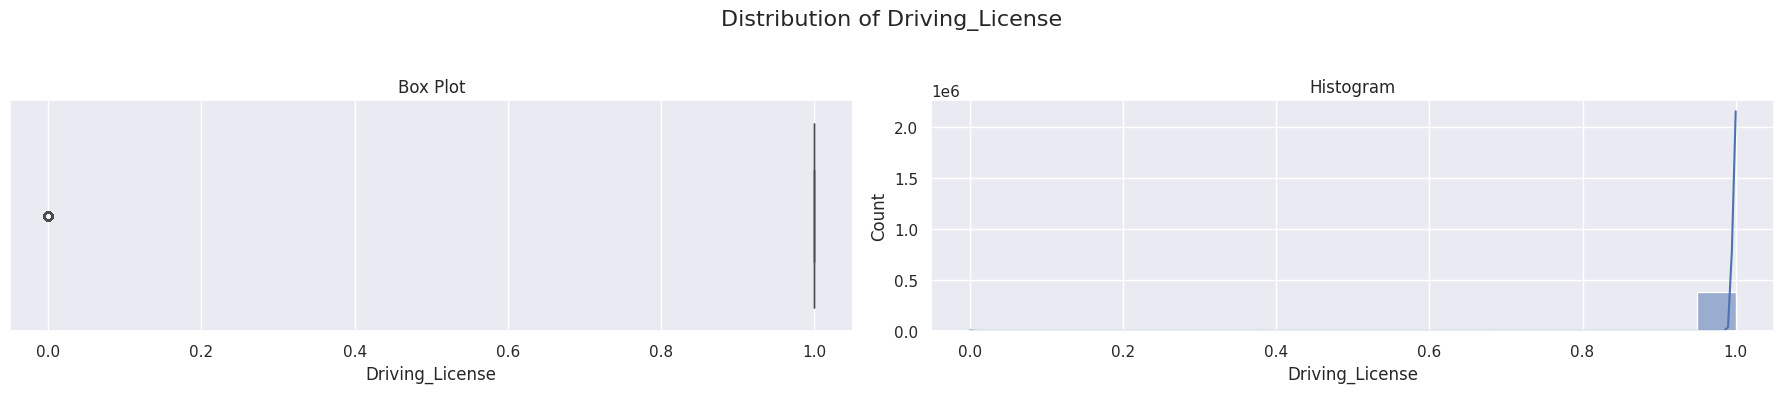

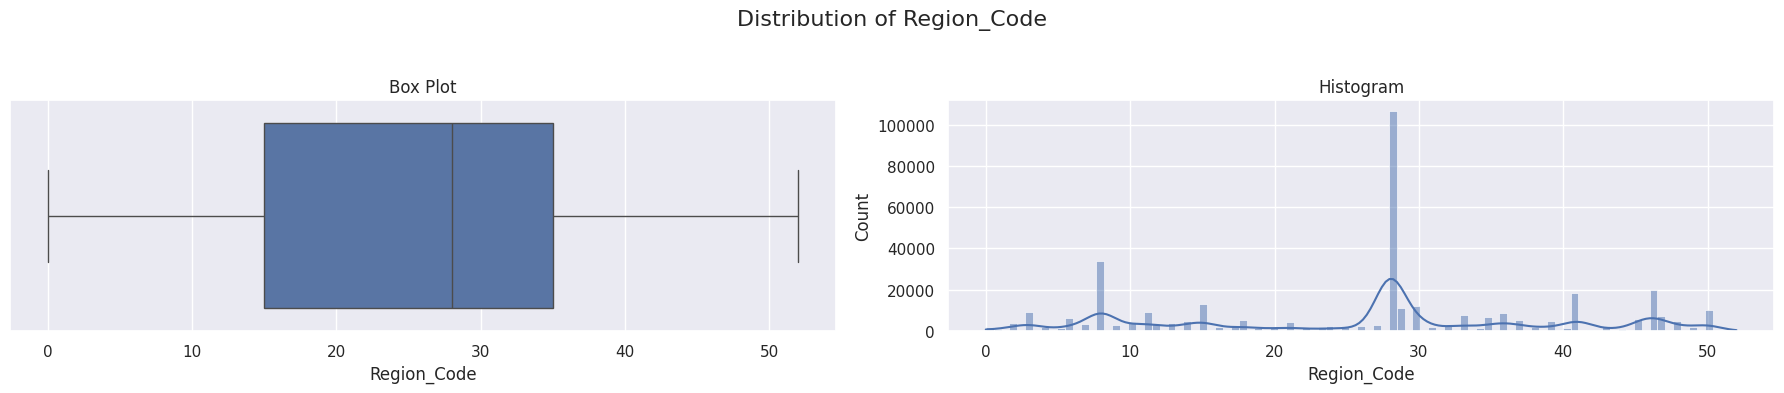

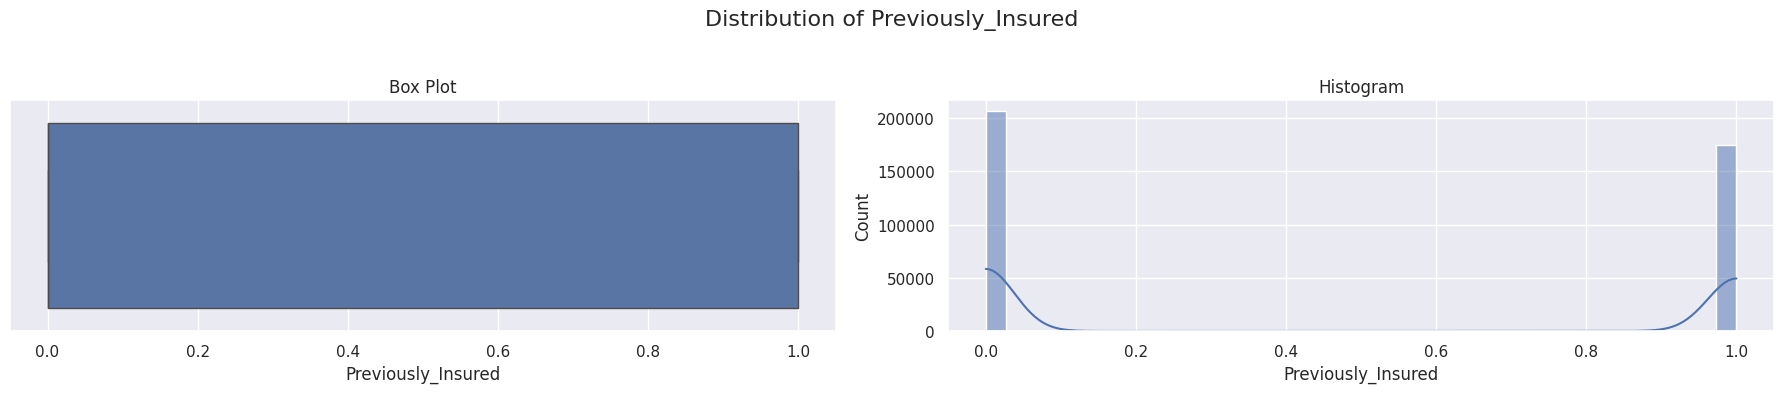

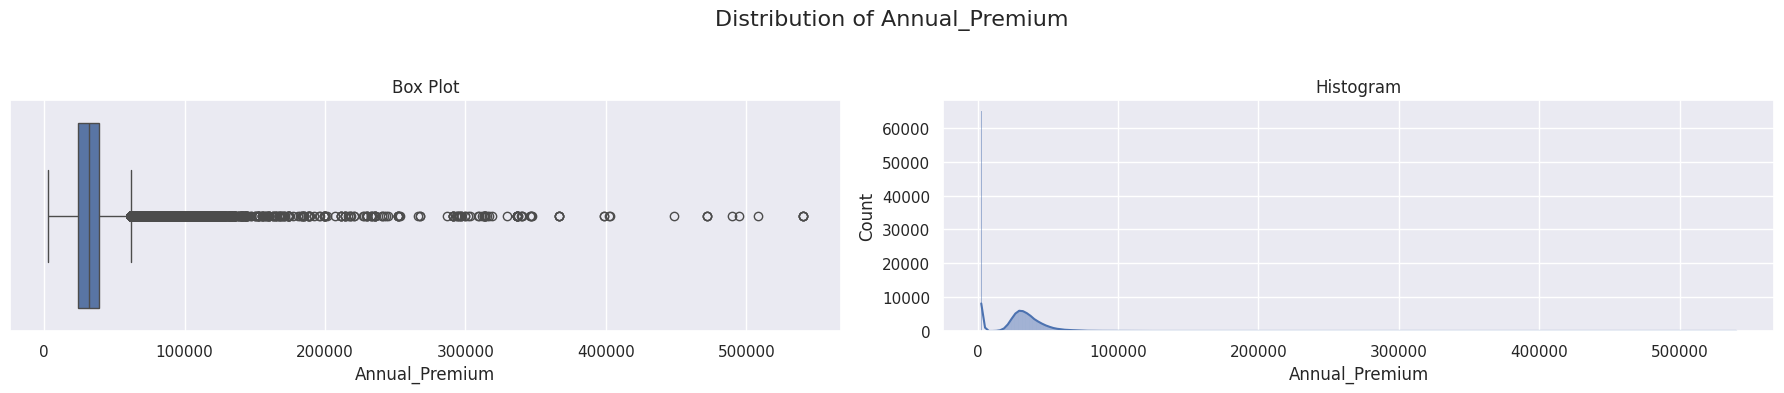

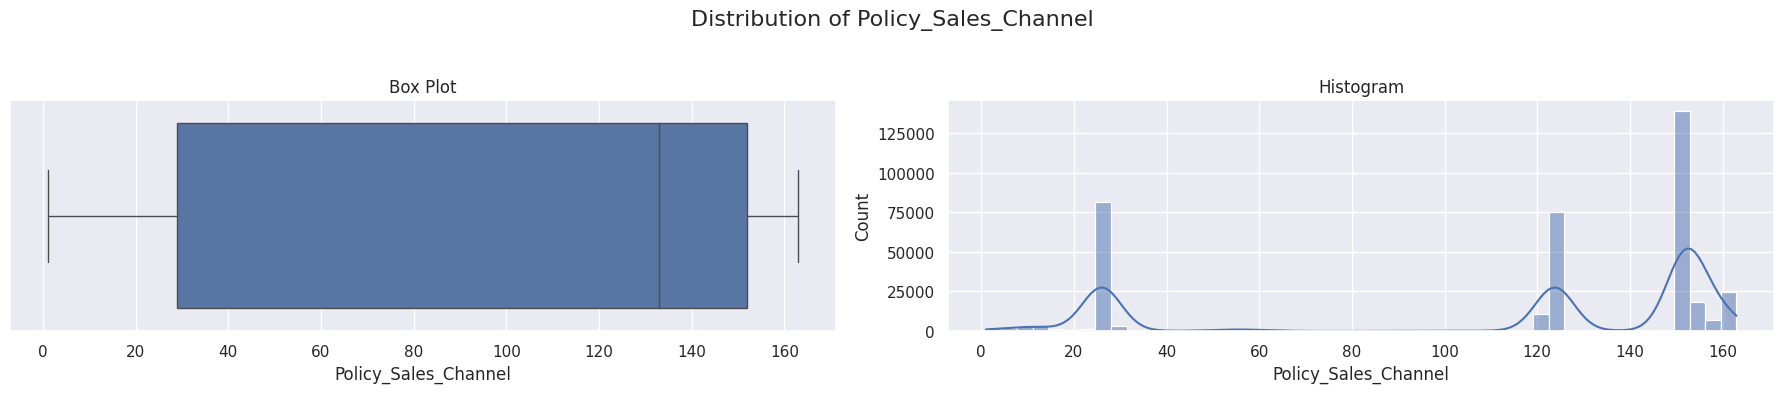

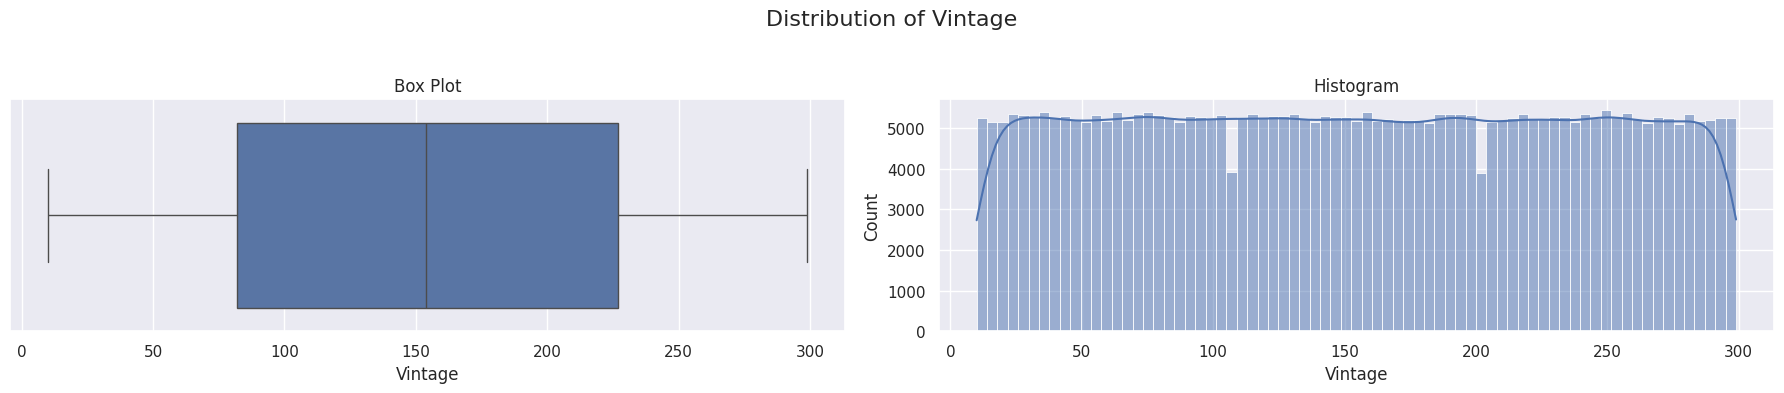

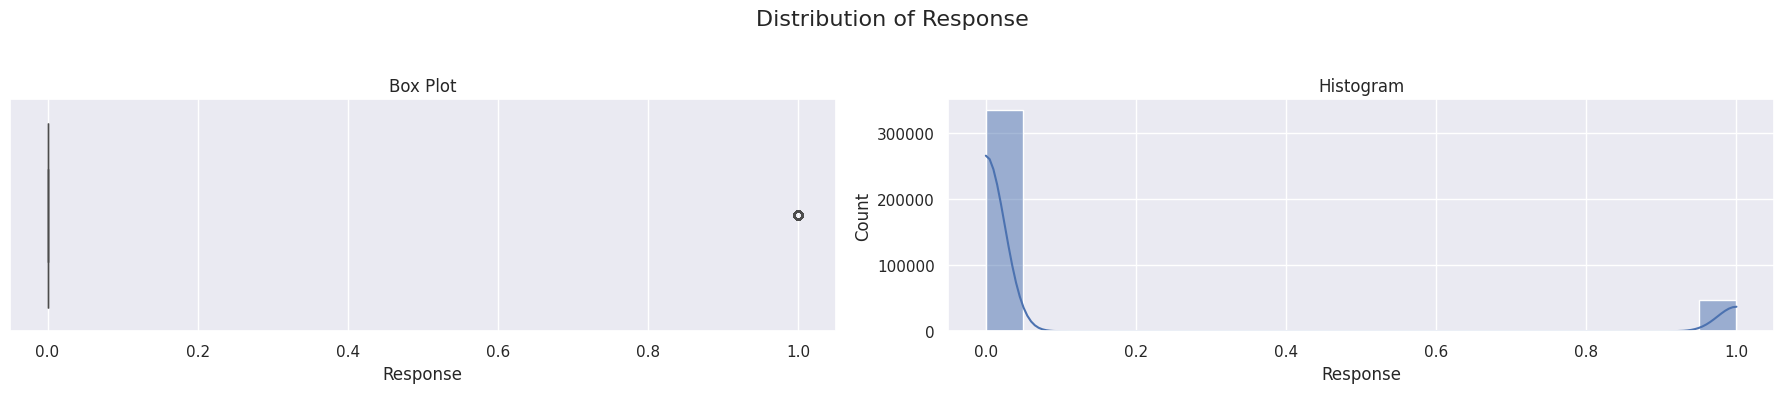

In [6]:


# Your DataFrame and column list would be defined here
# Example: df_raw = pd.DataFrame(...)
# Example: cols_to_evaluate = ['col_name_1', 'col_name_2']

for col in cols_to_evaluate:
    if df_raw[col].dtype in ('int64', 'float64'):
        # 1. Define the figure size
        plt.figure(figsize=(18, 4))
        
        # 2. BOXPLOT: Position 1 of 2
        plt.subplot(1, 2, 1) # <--- Corrected this to be 1, 2, 1
        sns.boxplot(x=df_raw[col])
        plt.title('Box Plot') # Optional: Add a title to the subplot
        
        # 3. HISTOGRAM: Position 2 of 2
        plt.subplot(1, 2, 2) # <--- Corrected this to be 1, 2, 2
        sns.histplot(x=df_raw[col], kde=True)
        plt.title('Histogram') # Optional: Add a title to the subplot
        
        # 4. Main title and display
        plt.suptitle(f'Distribution of {col}', fontsize=16) # Using f-string for clarity
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()

##### Conclusões

Apesar do campo Annual Premium, possuir claros outliers, isso não indica uma falha real no preenchimento dos dados, apenas expõe que existem clientes com valores de premio absurdamente maiores que outros (algo totalmente coerente/possível de ocorrer em uma seguradora de saúde)

# 2.0 Exploração dos dados

## 2.0.1 - Separação do dataset

Como possuímos uma boa quantidade de amostras, para evitar que a consutrução/modelagem do problema sofra algum vies inserido por algum conhecimento adquirido na análise exploratória, vamos separar o dataset em treino, teste e validação neste momento. Desta forma garantimos que não havera nenhum tipo de vazamento de dados 


In [7]:
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)

print(f'Train shape: {df_train.shape}'
      f'\nValidation shape: {df_val.shape}' 
      f'\nTest shape: {df_test.shape}')

df_1 = df_train.copy()
df_1.head()

Train shape: (243909, 12)
Validation shape: (60978, 12)
Test shape: (76222, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
217927,217928,Female,38,1,47.0,1,1-2 Year,No,32726.0,152.0,75,0
54207,54208,Male,21,1,46.0,1,< 1 Year,No,30429.0,160.0,123,0
18364,18365,Male,66,1,28.0,0,1-2 Year,Yes,54905.0,154.0,22,0
195540,195541,Female,41,1,28.0,1,1-2 Year,No,65737.0,26.0,260,0
30463,30464,Male,50,1,15.0,0,1-2 Year,Yes,39205.0,26.0,221,0


## 2.1 - Mapa de hipoteses

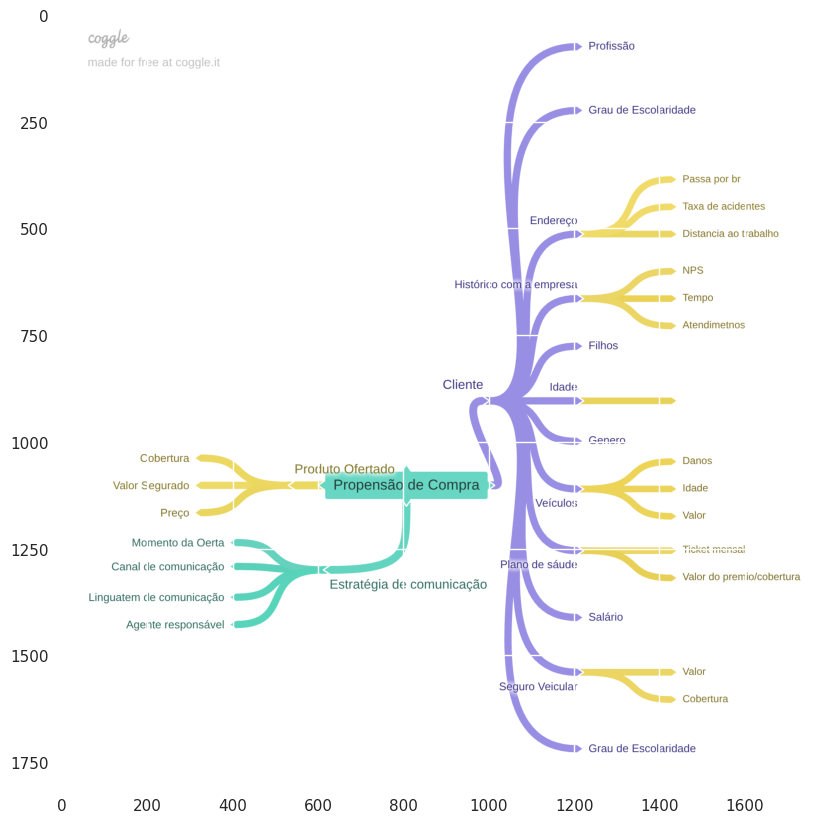

In [8]:
from matplotlib import pyplot as plt
import numpy as np 
from PIL import Image


img = Image.open('./media/propensao_de_compra_mind_map.png')
numpy = np.array(img)

plt.figure(figsize=(20, 10))
plt.imshow(numpy)

## 2.2 - Hipoteses:


**Cliente:**

1. ~~Clientes com maior grau de escolaridade possuem maior propensão de compra~~
2. ~~Clientes com Veiculos com preço mais elevado possuem maior propensão de compra~~
3. Clientes com mais tempo na base, possuem maior propensão de compra
4. Clientes com Ticket mais elevado possuem maior propensão de compra 
5. Clientes com Veiculos mais novos possuem maior propensão de compra 
6. Clientes com seguro veicular possuem menor propensão de compra 
7. Existem regiões, onde os clientes possuem maior propensão de compra
8. Clientes com veiculos que ja sofreram danos, possuem maior propensão a aquisição do seguro 
9. Clientes com mais de 30 anos, são mais propensos a adquirir o seguro.
10. ~~Clientes com Salario mais elevado, possuem maior propensão~~
11. Clientes do sexo feminino, possuem maior propensão a aquisição de seguros veiculares
12. Clientes alcancados pelo canal 2, tem maior propensao de compra

**Estrategia de comunicação**

1. ~~Abordagems em canais de telefonia, elevam a propensão de compra do cliente.~~ 
2. ~~Ofertas realizadas a clientes no inicio do dia, elevam a propensão de compra~~
3. ~~O agente quiabo, eleva a propensão de compra~~

**Produto:**

1. ~~Seguros com maior relação (valor_cobertura/preço) possuem maior propensão de compra.~~ 

## 2.3 - Validando Hipoteses

### 2.3.1 - Clientes

#### H3 - Clientes com mais tempo na base possuem maior propensão de compra

**Falsa**

<Axes: xlabel='Vintage', ylabel='Response'>

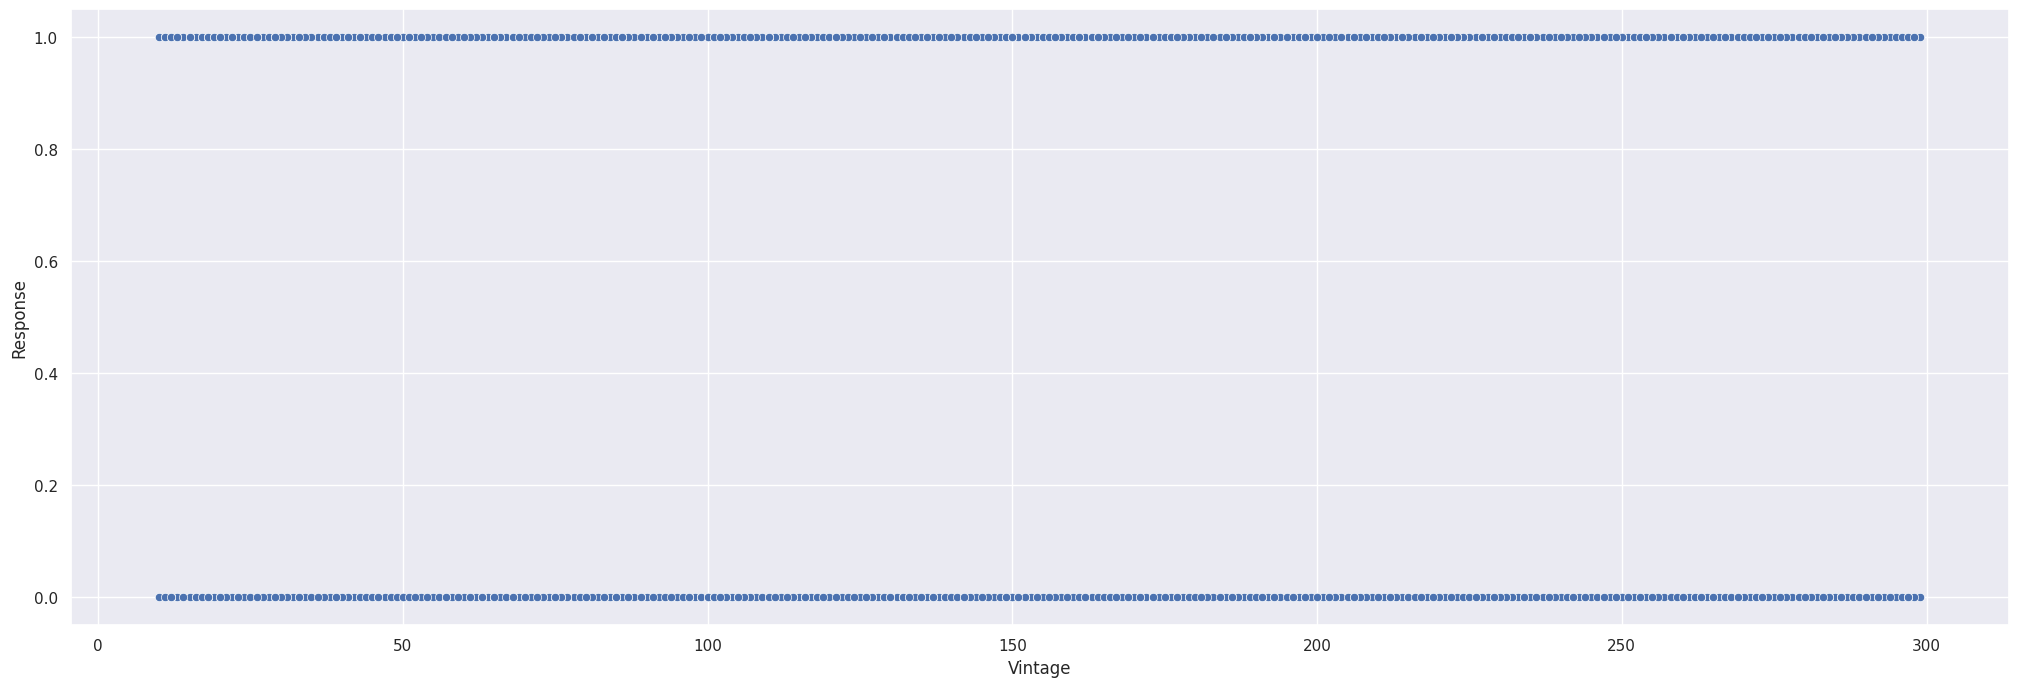

In [9]:
sns.scatterplot(data = df_1,x='Vintage', y='Response')

In [10]:
df_1[df_1.Response == 1]['Vintage'].describe()

count    29699.000000
mean       154.000572
std         83.562694
min         10.000000
25%         82.000000
50%        154.000000
75%        225.000000
max        299.000000
Name: Vintage, dtype: float64

In [11]:
df_1[df_1.Response == 0]['Vintage'].describe()

count    214210.000000
mean        154.271505
std          83.599469
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

<Axes: xlabel='Vintage', ylabel='Density'>

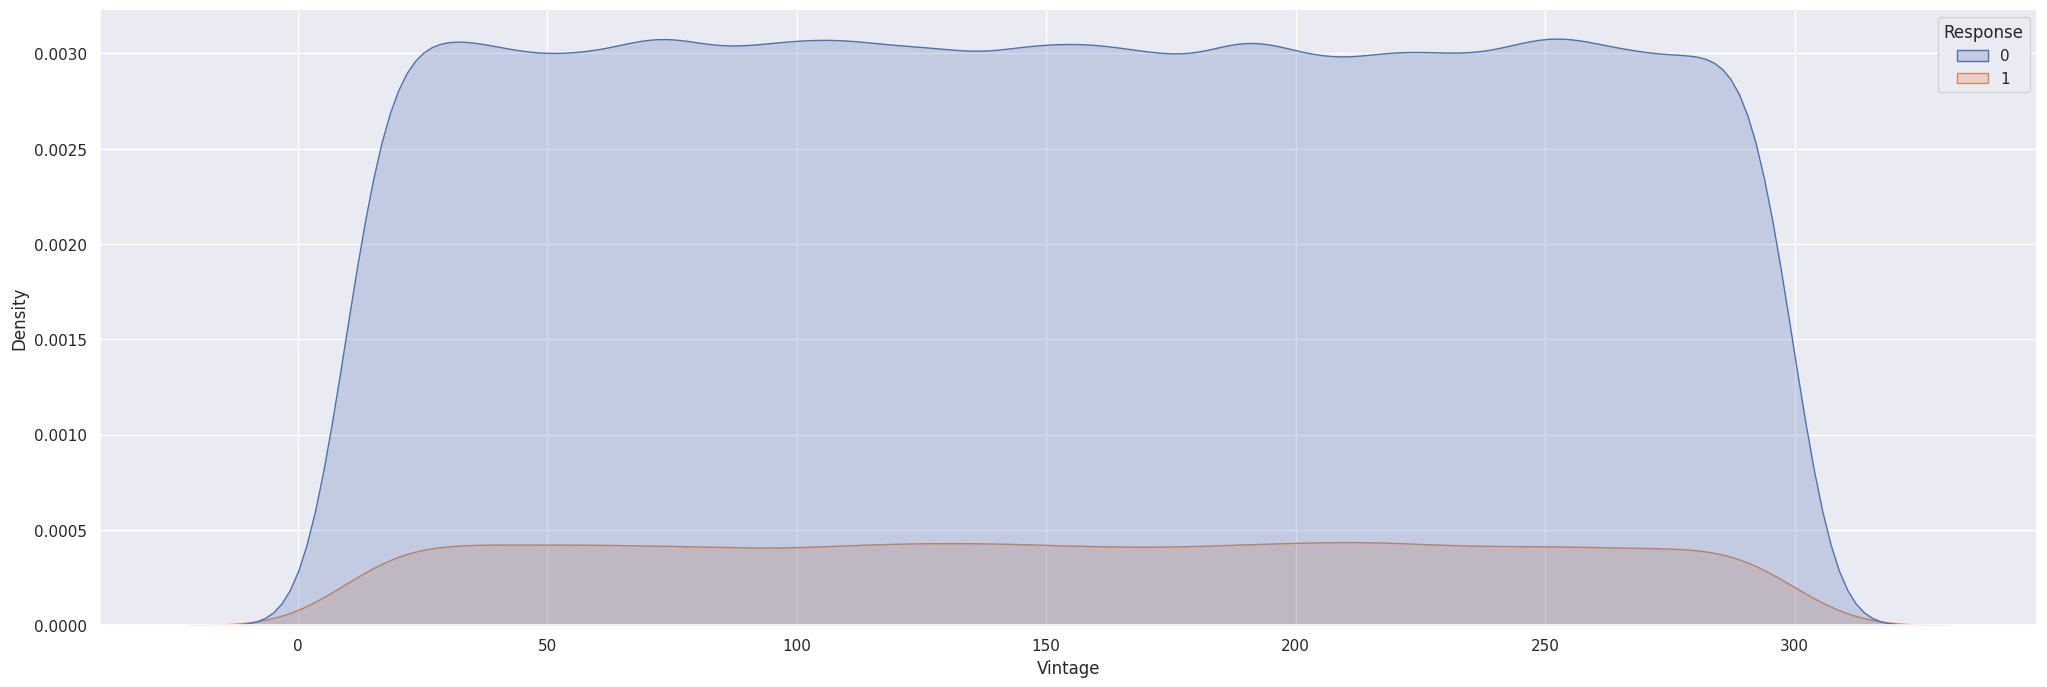

In [12]:
sns.kdeplot(data = df_1, x='Vintage', hue='Response', fill=True, label = 'Response')

**Conclusão:** Falso, o vintage possuí impacto algum sobre a decisão de adquirir ou não adquirir um seguro veicular

### H4. Clientes com ticket mais elevado, possuem maior propensão de compra

**Conclusão:** Falso, o interesse do cliente em comprar ou não comprar, não é influenciado pelo annual premium pago pelo cliente

In [13]:
print('**Clientes que adquiririam o Seguro**')
print(df_1[df_1.Response == 1].Annual_Premium.describe())

print('-'*45)
print('**Clientes NAO que adquiririam o Seguro**')

print(df_1[df_1.Response == 0].Annual_Premium.describe())

**Clientes que adquiririam o Seguro**
count     29699.000000
mean      31619.772551
std       18557.744433
min        2630.000000
25%       24943.000000
50%       33009.000000
75%       41283.500000
max      540165.000000
Name: Annual_Premium, dtype: float64
---------------------------------------------
**Clientes NAO que adquiririam o Seguro**
count    214210.000000
mean      30403.955964
std       17024.481880
min        2630.000000
25%       24331.000000
50%       31508.000000
75%       39117.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


<Axes: xlabel='Annual_Premium', ylabel='Density'>

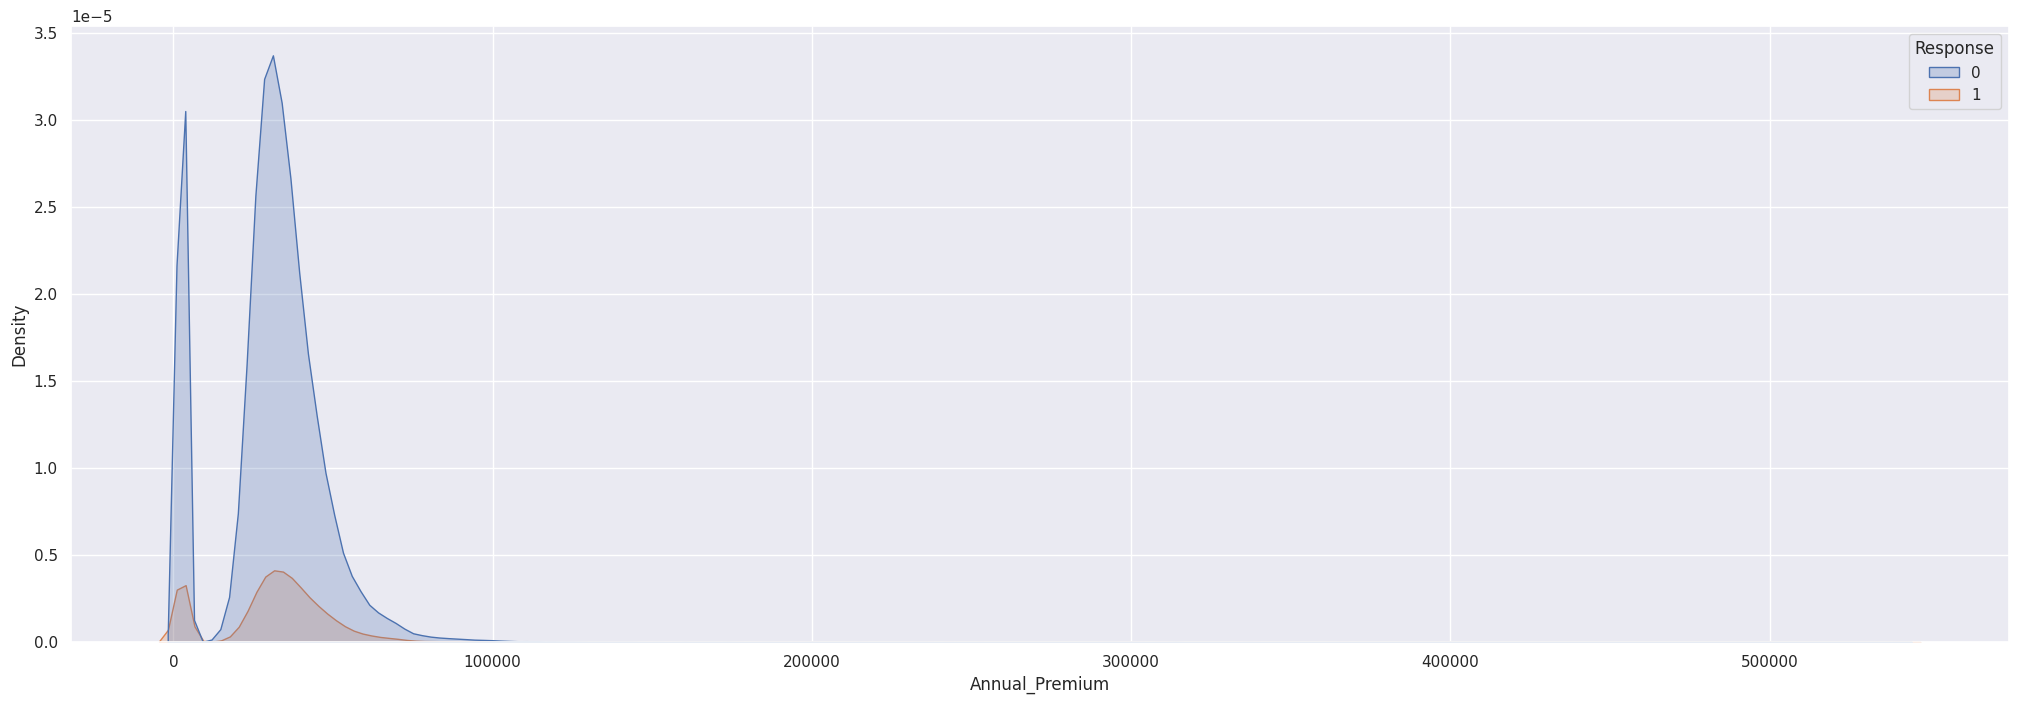

In [14]:
sns.kdeplot(data = df_1, x='Annual_Premium', hue='Response', fill=True, label = 'Response')

### H5 - Clientes com veículos mais novos possuem maior propensão de compra

**Conclusão:** Falsa, na realidade clientes com veiculos mais antigos, no geral, possuem uma maior tendencia a adquirir o seguro, que clientes com veículos mais novos

In [15]:
df_1.Vehicle_Age.value_counts()
df_1.loc[:,'Vehicle_Age'] = df_1.loc[:,'Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})



df_vehicle_age = get_frequency_table(df_1, 'Vehicle_Age')
df_vehicle_age


,Vehicle_Age,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
0,0,4574,100809,105383,0.043404,0.154012,0.470608,0.432059,0.121763
1,1,22106,106175,128281,0.172325,0.744335,0.495658,0.525938,0.121763
2,2,3019,7226,10245,0.294680,0.101653,0.033733,0.042003,0.121763


<Axes: xlabel='Vehicle_Age', ylabel='Propensity_to_buy'>

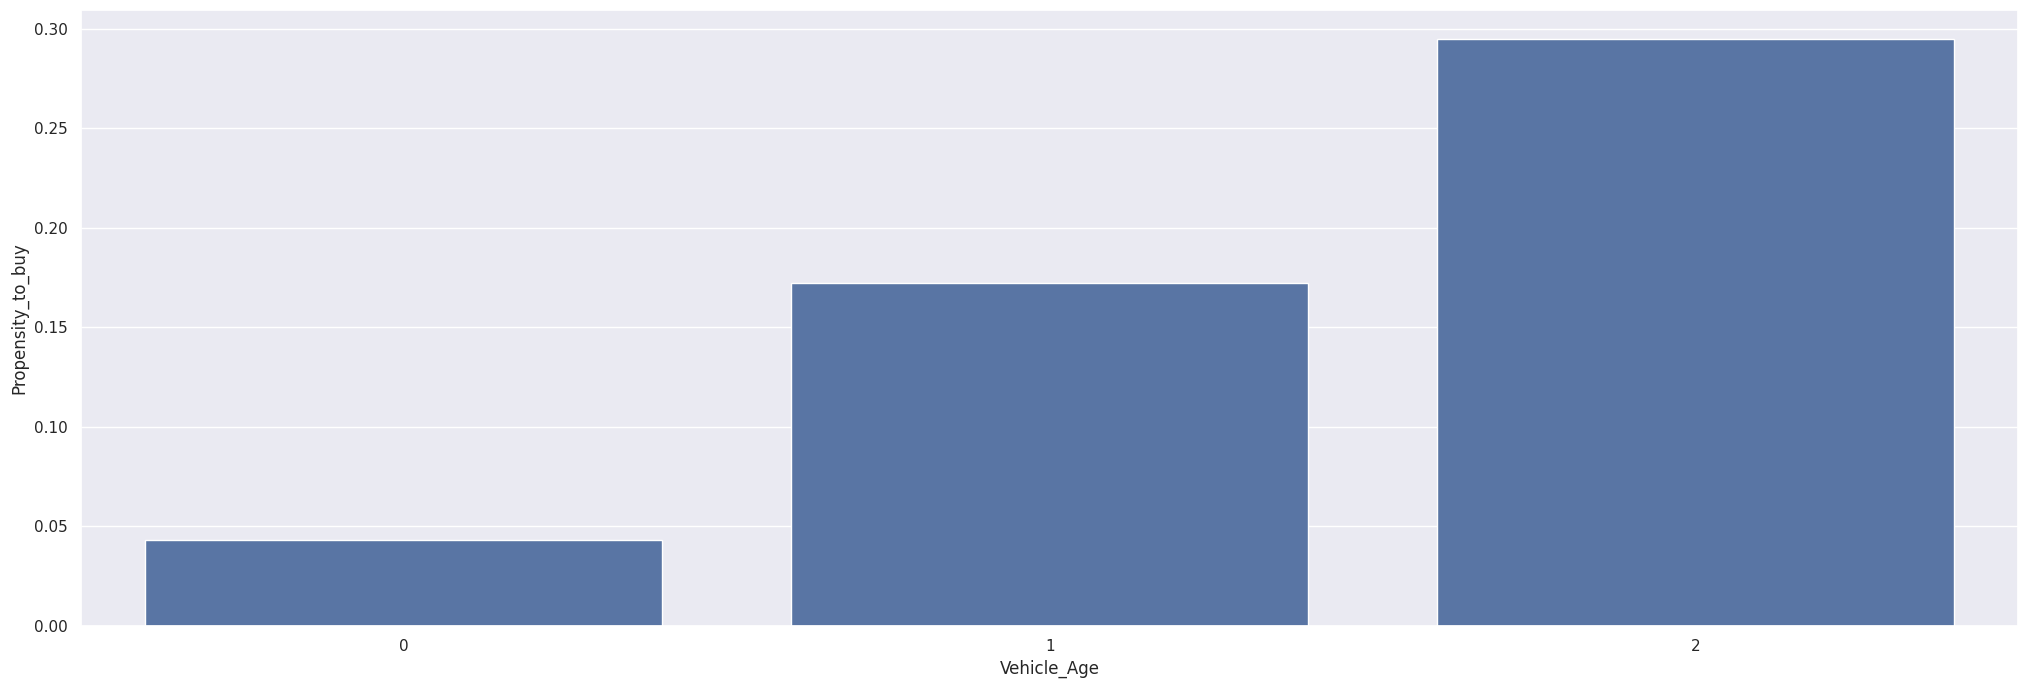

In [16]:
sns.barplot(data=df_vehicle_age, x='Vehicle_Age', y='Propensity_to_buy')

### H6 - Clientes com seguro veicular possuem menor propensão de compra

**Conclusão:** Verdadeira, clientes que já possuem seguro veicular, possuem uma propensão de compra muuito menor, em relação aos que não possuem. Praticamente todos os clientes que disseram comprar o seguro ofertado pela empresa, não possuem um seguro previo > (99%)

In [17]:
df_previously_insured = get_frequency_table(df_1, 'Previously_Insured')
df_previously_insured

,Previously_Insured,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
0,0,29599,102546,132145,0.223989,0.996633,0.478717,0.54178,0.121763
1,1,100,111664,111764,0.000895,0.003367,0.521283,0.45822,0.121763


Text(0.5, 1.0, 'Propensão de compra x Previously_Insured')

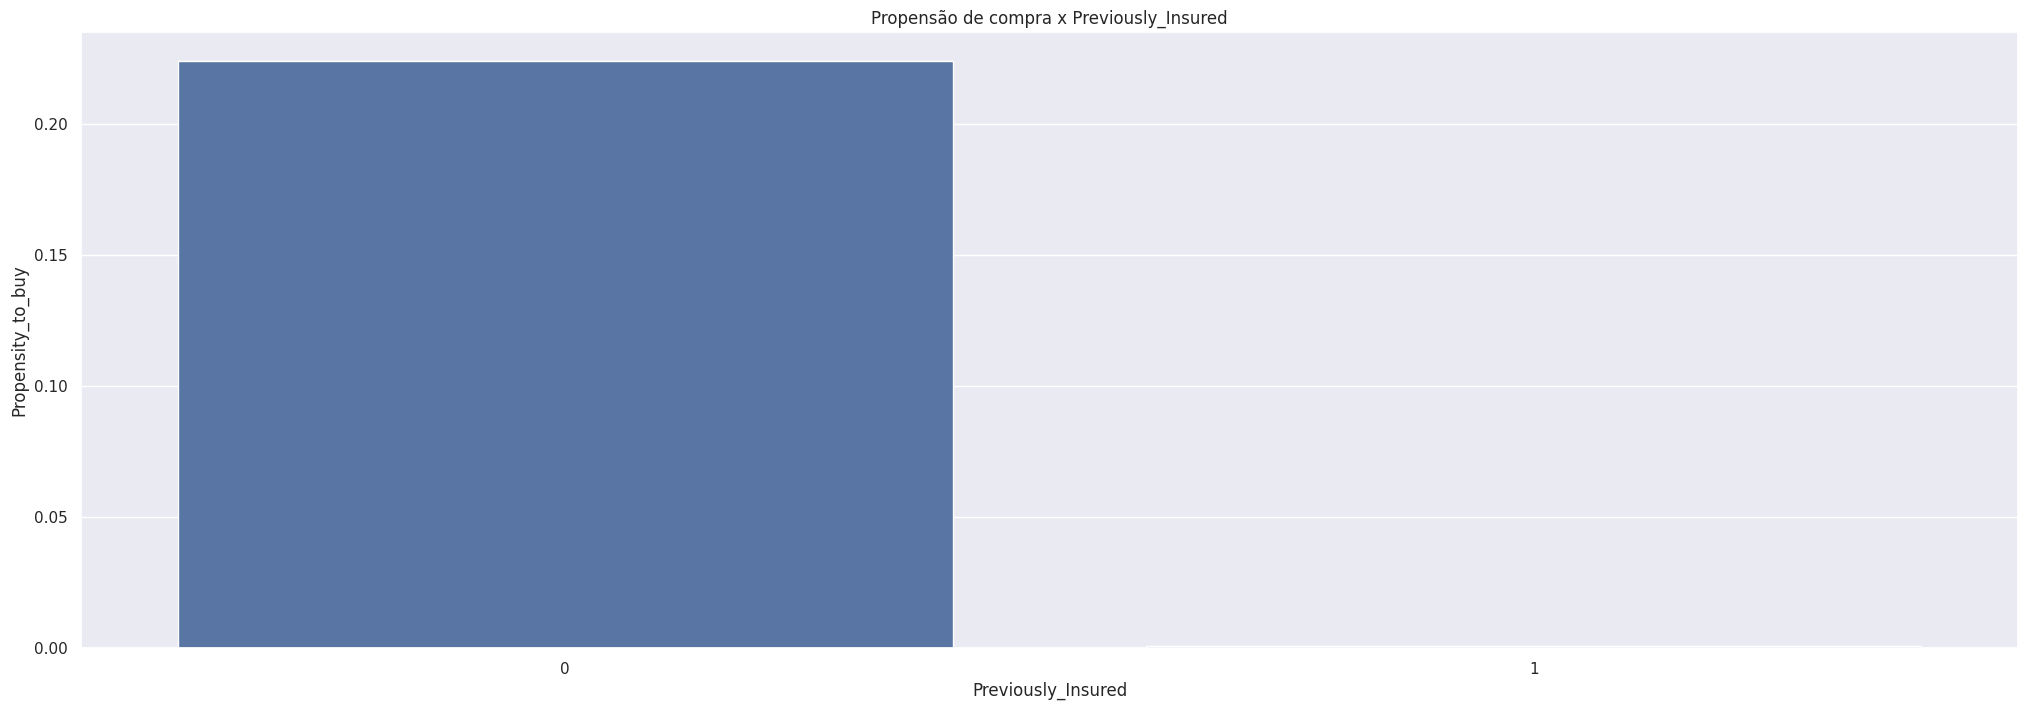

In [18]:
sns.barplot(data=df_previously_insured, x='Previously_Insured', y='Propensity_to_buy')
plt.title('Propensão de compra x Previously_Insured')

### H7. Existem regiões, onde os clientes possuem maior propensão de compra

**Conclusão:** Sim, ha regiões com maior propensão de compra, que outras, inclusive, a região mais interessate é a região com codigo 28, cujo 18% dos entrevistados comprariam o produto, além da região concentrar cerca de 28% dos entrevistados 

In [19]:
df_1.Region_Code.nunique()

53

In [20]:
df_region_code = get_frequency_table(df_1, 'Region_Code')
df_region_code.sort_values(by='Propensity_to_buy', ascending=False).head(25)

,Region_Code,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
38,38.0,251,1007,1258,0.199523,0.008451,0.004701,0.005158,0.121763
28,28.0,12693,55503,68196,0.186125,0.427388,0.259106,0.279596,0.121763
19,19.0,165,846,1011,0.163205,0.005556,0.003949,0.004145,0.121763
4,4.0,173,968,1141,0.151621,0.005825,0.004519,0.004678,0.121763
51,51.0,17,96,113,0.150442,0.000572,0.000448,0.000463,0.121763
23,23.0,187,1061,1248,0.149840,0.006297,0.004953,0.005117,0.121763
24,24.0,225,1353,1578,0.142586,0.007576,0.006316,0.006470,0.121763
7,7.0,283,1782,2065,0.137046,0.009529,0.008319,0.008466,0.121763
52,52.0,24,162,186,0.129032,0.000808,0.000756,0.000763,0.121763
18,18.0,423,2897,3320,0.127410,0.014243,0.013524,0.013612,0.121763


Text(0.5, 1.0, 'Propensão de compra x Region_Code')

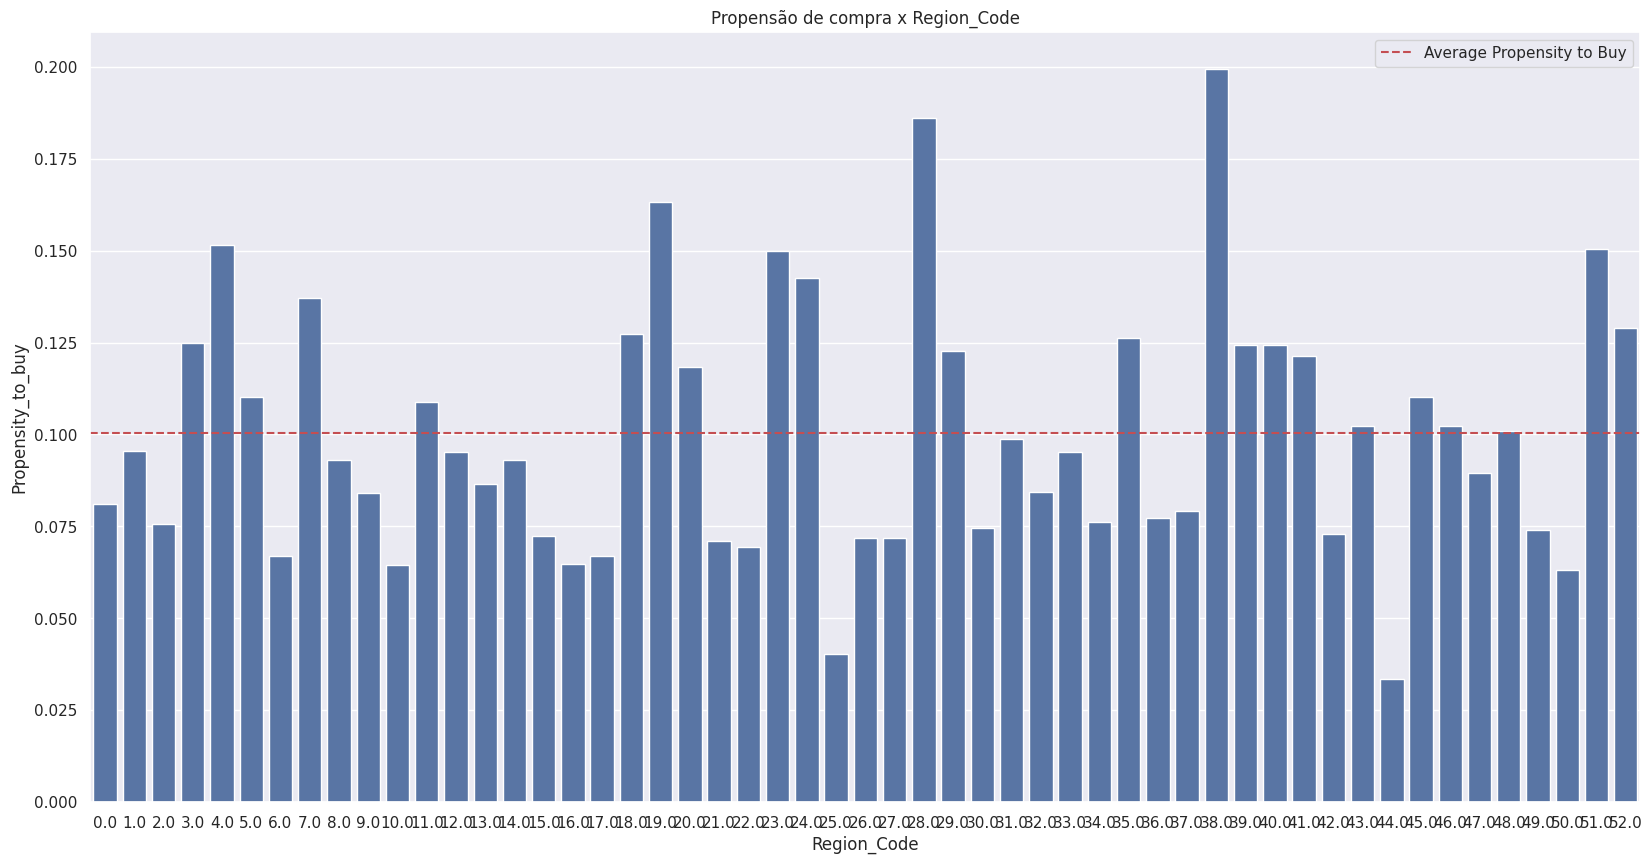

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.axhline(y=df_region_code.Propensity_to_buy.mean(), color='r', linestyle='--', label='Average Propensity to Buy')
sns.barplot(data=df_region_code, x='Region_Code', y='Propensity_to_buy')
plt.title('Propensão de compra x Region_Code')

### H8. Clientes com veiculos que ja sofreram danos, possuem maior propensão a aquisição do seguro 

**Conclusão** Verdadeiro, clientes que ja tiveram algum tipo de dano veicular, possuem uma tendencia a aquisição de um seguro muito maior, que clientes que nunca tiveram (23% vs 0.5%)

In [22]:
df_vehicle_damage = get_frequency_table(df_1, 'Vehicle_Damage')
df_vehicle_damage.sort_values(by='Propensity_to_buy', ascending=False)


,Vehicle_Damage,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
1,Yes,29074,94174,123248,0.235898,0.978956,0.439634,0.505303,0.121763
0,No,625,120036,120661,0.005180,0.021044,0.560366,0.494697,0.121763


### H9. Clientes com mais de 30 anos, são mais propensos a adquirir o seguro.

**Conclusão:** Falso, na realidade de fato clientes na faixa dos 30 anos são mais propensos a adquirir um seguro, porem essa propensão se extende somente até os clientes com faixa etaria dos 40 anos, a partir dos 50, essa propensão passa a diminuir


In [23]:
print_descriptive_stats(df_1, 'Age')

**Clientes que adquiririam o Seguro - Age statistics**
count    29699.000000
mean        43.512846
std         12.188968
min         20.000000
25%         35.000000
50%         43.000000
75%         51.000000
max         83.000000
Name: Age, dtype: float64
---------------------------------------------
**Clientes NAO que adquiririam o Seguro - Age statistics**
count    214210.000000
mean         38.169282
std          15.812357
min          20.000000
25%          24.000000
50%          34.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64




In [24]:
df_age = get_frequency_table(df_1, 'Age')
df_age.sort_values(by='Propensity_to_buy', ascending=False).head(20)

,Age,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
18,38,832,2802,3634,0.228949,0.028014,0.013081,0.014899,0.121763
15,35,714,2466,3180,0.224528,0.024041,0.011513,0.013038,0.121763
16,36,731,2530,3261,0.224164,0.024614,0.011812,0.013370,0.121763
27,47,1019,3616,4635,0.219849,0.034311,0.016882,0.019003,0.121763
14,34,670,2437,3107,0.215642,0.022560,0.011377,0.012738,0.121763
20,40,999,3645,4644,0.215116,0.033637,0.017017,0.019040,0.121763
19,39,866,3190,4056,0.213511,0.029159,0.014893,0.016629,0.121763
26,46,1083,3997,5080,0.213189,0.036466,0.018660,0.020827,0.121763
25,45,1118,4127,5245,0.213155,0.037644,0.019267,0.021504,0.121763
13,33,691,2553,3244,0.213009,0.023267,0.011919,0.013300,0.121763


<Axes: xlabel='Age', ylabel='Density'>

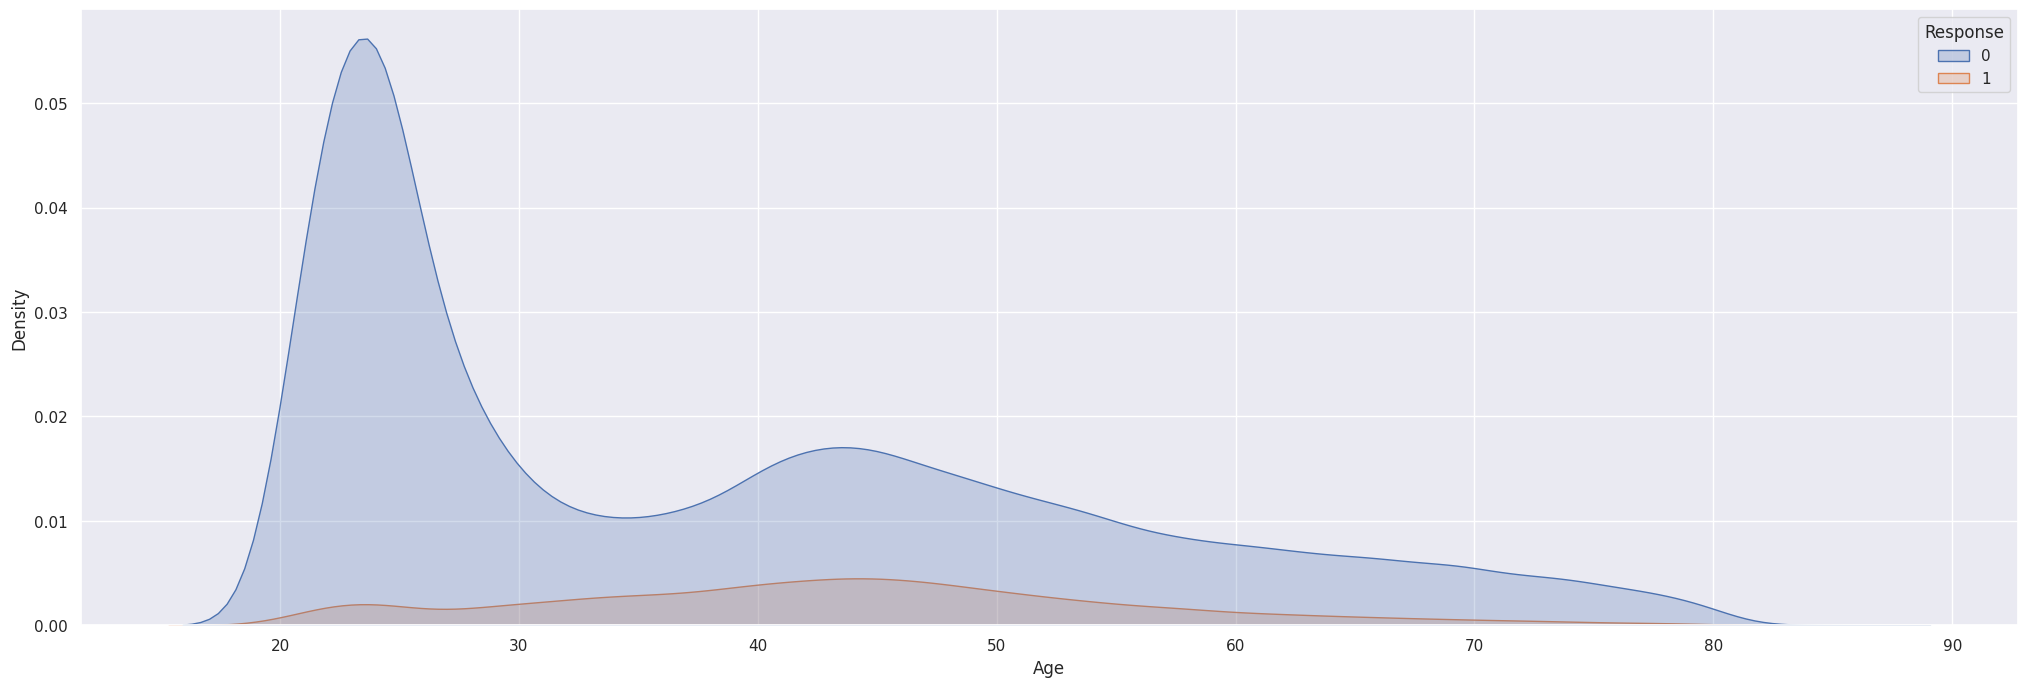

In [25]:
sns.kdeplot(data = df_1, x='Age', hue='Response', fill=True, label = 'Response')

In [26]:
df_1['faixa_etaria'] = df_1.Age.apply(lambda x: int(x/10)*10)
df_faixa_etaria = get_frequency_table(df_1, 'faixa_etaria')
df_faixa_etaria.sort_values(by = 'Propensity_to_buy', ascending = False)

,faixa_etaria,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
2,40,10329,38950,49279,0.209602,0.347789,0.181831,0.202038,0.121763
1,30,6837,27854,34691,0.197083,0.230210,0.130031,0.142229,0.121763
3,50,5478,25216,30694,0.178471,0.184451,0.117716,0.125842,0.121763
4,60,2152,16432,18584,0.115799,0.072460,0.076710,0.076192,0.121763
5,70,818,9902,10720,0.076306,0.027543,0.046226,0.043951,0.121763
6,80,31,612,643,0.048212,0.001044,0.002857,0.002636,0.121763
0,20,4054,95244,99298,0.040827,0.136503,0.444629,0.407111,0.121763


<Axes: xlabel='faixa_etaria', ylabel='Density'>

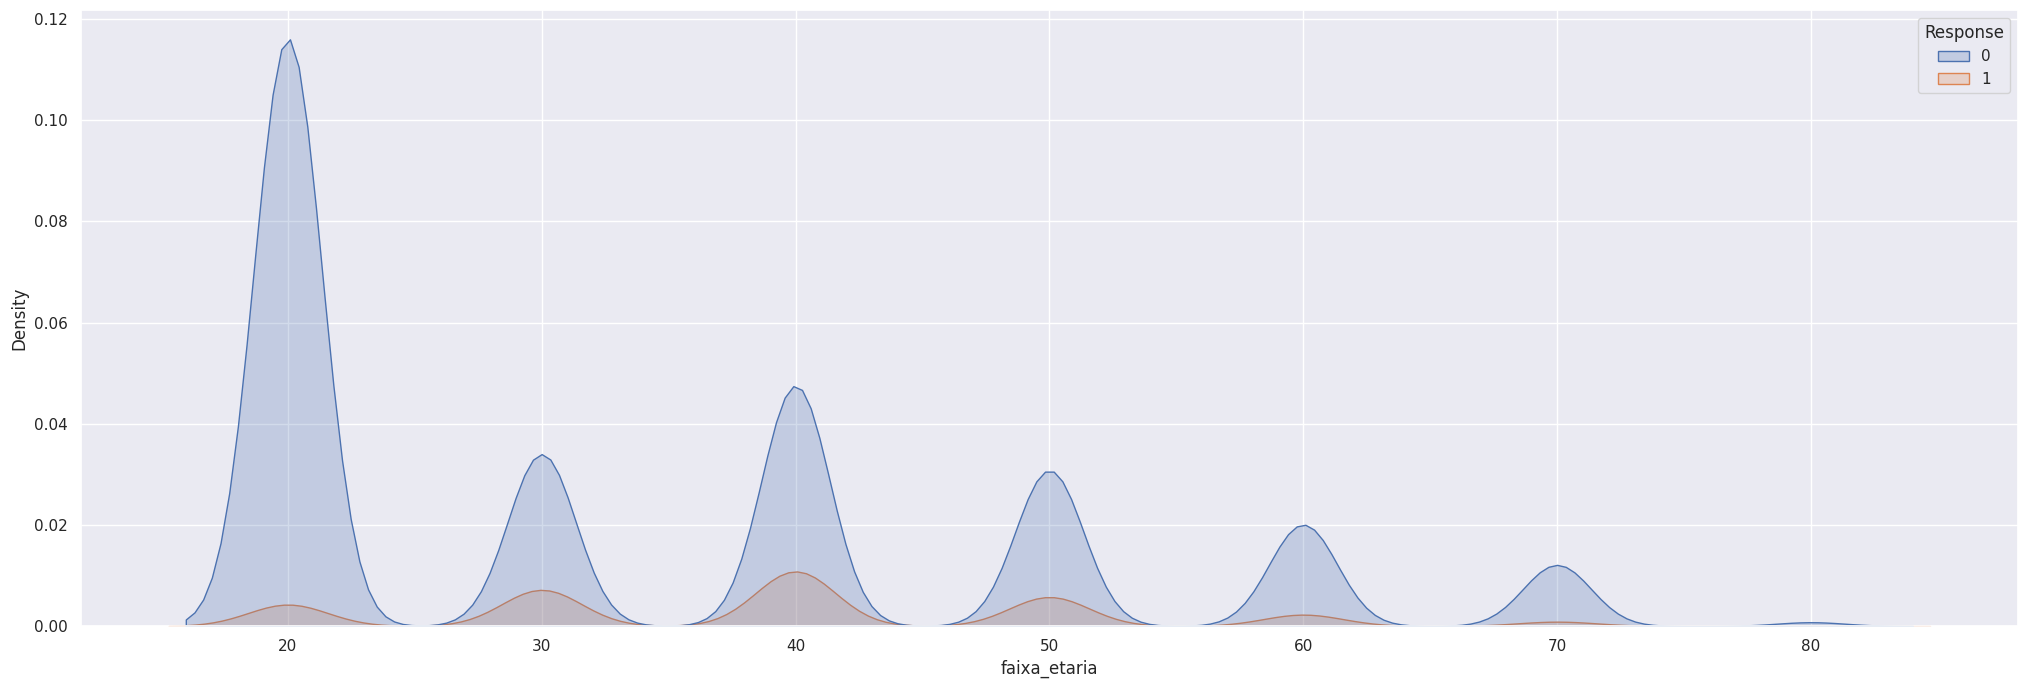

In [27]:
sns.kdeplot(data = df_1, x='faixa_etaria', hue='Response', fill=True, label = 'Response')

<Axes: xlabel='faixa_etaria', ylabel='Propensity_to_buy'>

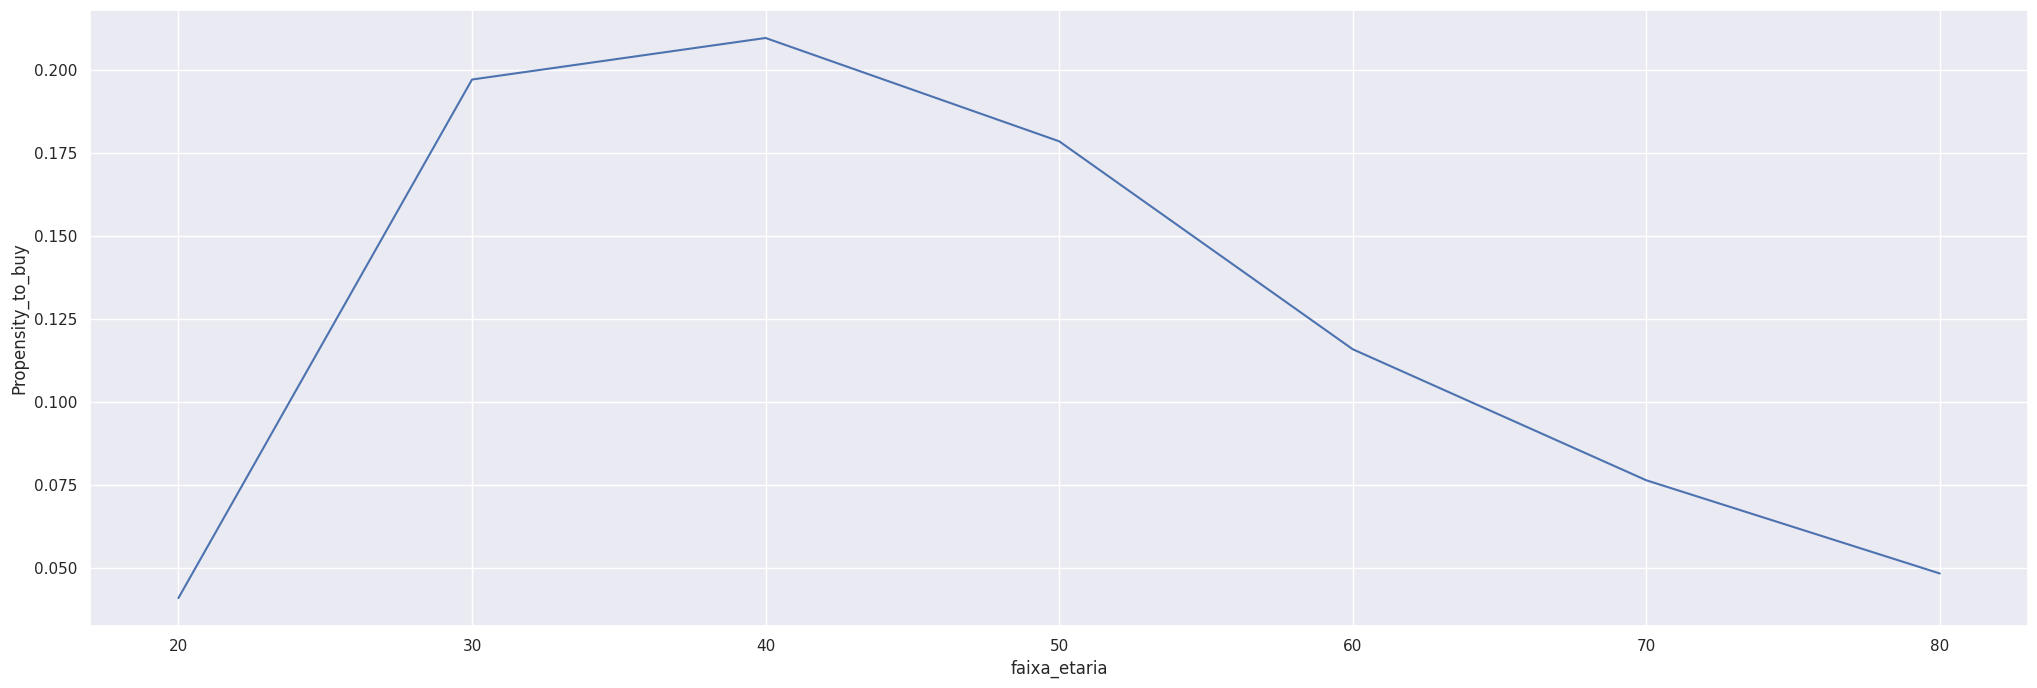

In [28]:
sns.lineplot(data = df_faixa_etaria, x = 'faixa_etaria', y = 'Propensity_to_buy',)

### H11. Clientes do sexo feminino, possuem maior propensão a aquisição de seguros veiculares


**Conclusão: Falso**, clientes do sexo masculino, possuem uma probabilidade de comprarem o seguro 3% maiore que homens. 

In [29]:
df_gender = get_frequency_table(df_1, 'Gender')
df_gender

,Gender,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
0,Female,11582,100623,112205,0.103222,0.389979,0.46974,0.460028,0.121763
1,Male,18117,113587,131704,0.137558,0.610021,0.53026,0.539972,0.121763


<Axes: xlabel='Gender', ylabel='Propensity_to_buy'>

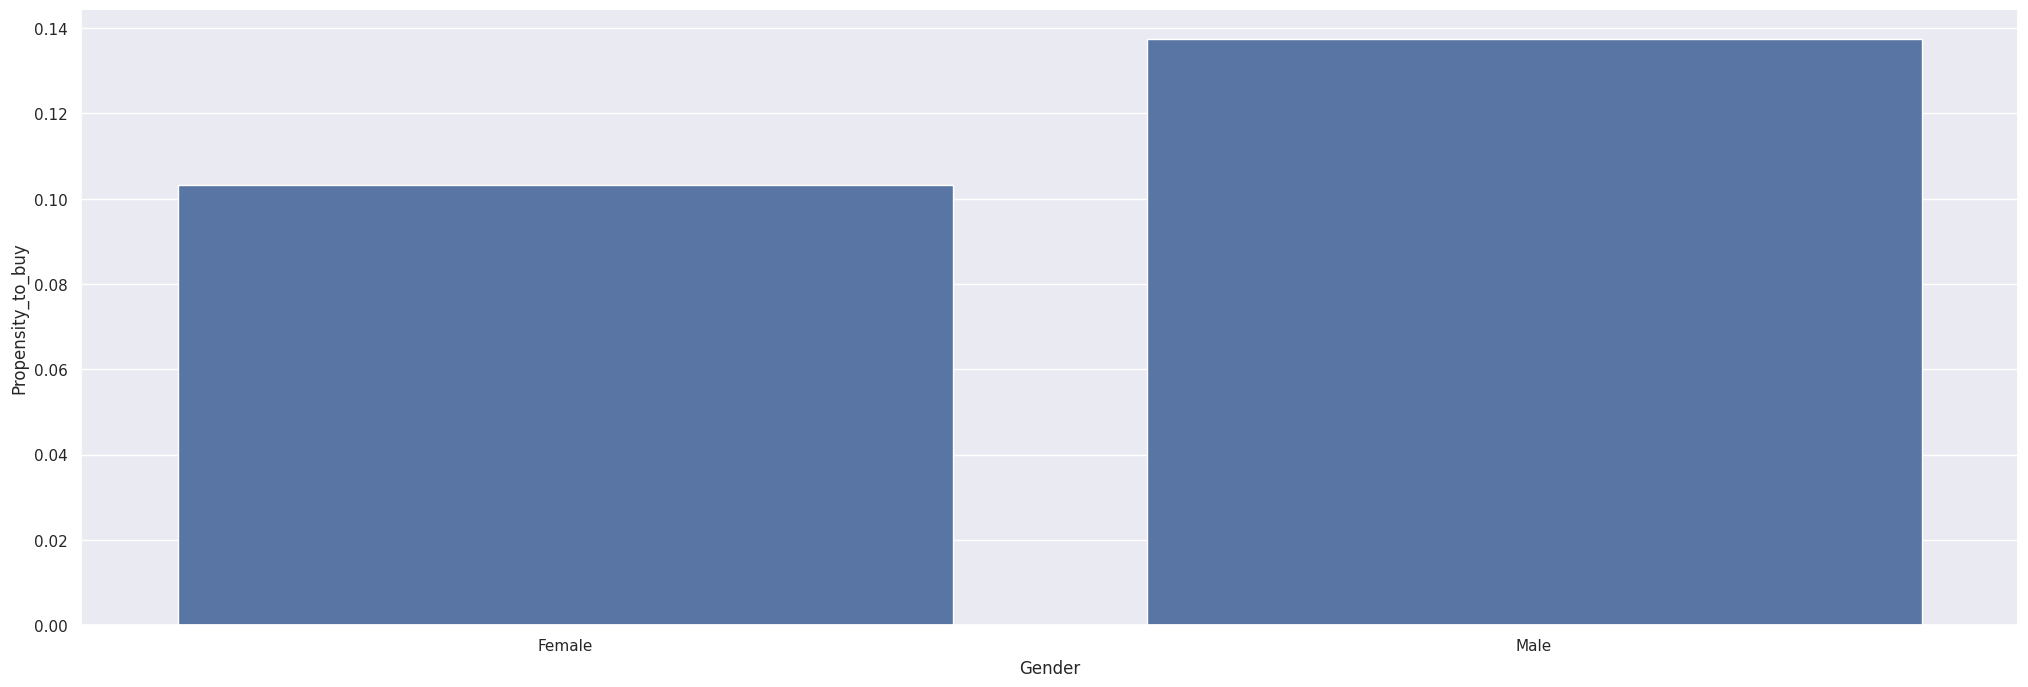

In [30]:
sns.barplot(data = df_gender, x='Gender', y='Propensity_to_buy')

### H12 - Clientes alcançados pelo canal 2, possuem maior propensão de compra

In [44]:
df_sales_channel = get_frequency_table(df_1, 'Policy_Sales_Channel')
df_sales_channel.sort_values(by='Propensity_to_buy', ascending=False).head(10)

,Policy_Sales_Channel,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
63,101.0,2,2,4,0.500000,0.000067,0.000009,0.000016,0.121763
75,121.0,16,31,47,0.340426,0.000539,0.000145,0.000193,0.121763
62,100.0,2,4,6,0.333333,0.000067,0.000019,0.000025,0.121763
55,90.0,5,11,16,0.312500,0.000168,0.000051,0.000066,0.121763
51,81.0,3,7,10,0.300000,0.000101,0.000033,0.000041,0.121763
50,80.0,3,7,10,0.300000,0.000101,0.000033,0.000041,0.121763
98,155.0,234,551,785,0.298089,0.007880,0.002575,0.003218,0.121763
1,3.0,102,241,343,0.297376,0.003435,0.001126,0.001406,0.121763
104,163.0,557,1324,1881,0.296119,0.018757,0.006187,0.007712,0.121763
100,157.0,1161,3122,4283,0.271072,0.039096,0.014588,0.017560,0.121763


In [ ]:

df_sales_channel.sort_values(by='Propensity_to_buy', ascending=False).tail(10)

,Policy_Sales_Channel,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
47,64.0,3,54,57,0.052632,0.000101,0.000252,0.000234,0.121763
18,22.0,10,190,200,0.050000,0.000337,0.000888,0.000820,0.121763
94,151.0,87,2364,2451,0.035496,0.002930,0.011046,0.010049,0.121763
14,18.0,4,112,116,0.034483,0.000135,0.000523,0.000476,0.121763
0,1.0,23,655,678,0.033923,0.000775,0.003061,0.002780,0.121763
73,119.0,2,57,59,0.033898,0.000067,0.000266,0.000242,0.121763
102,159.0,1,30,31,0.032258,0.000034,0.000140,0.000127,0.121763
66,107.0,1,31,32,0.031250,0.000034,0.000145,0.000131,0.121763
95,152.0,2416,83775,86191,0.028031,0.081358,0.391455,0.353374,0.121763
103,160.0,292,13616,13908,0.020995,0.009833,0.063623,0.057021,0.121763


<Axes: xlabel='Policy_Sales_Channel', ylabel='Propensity_to_buy'>

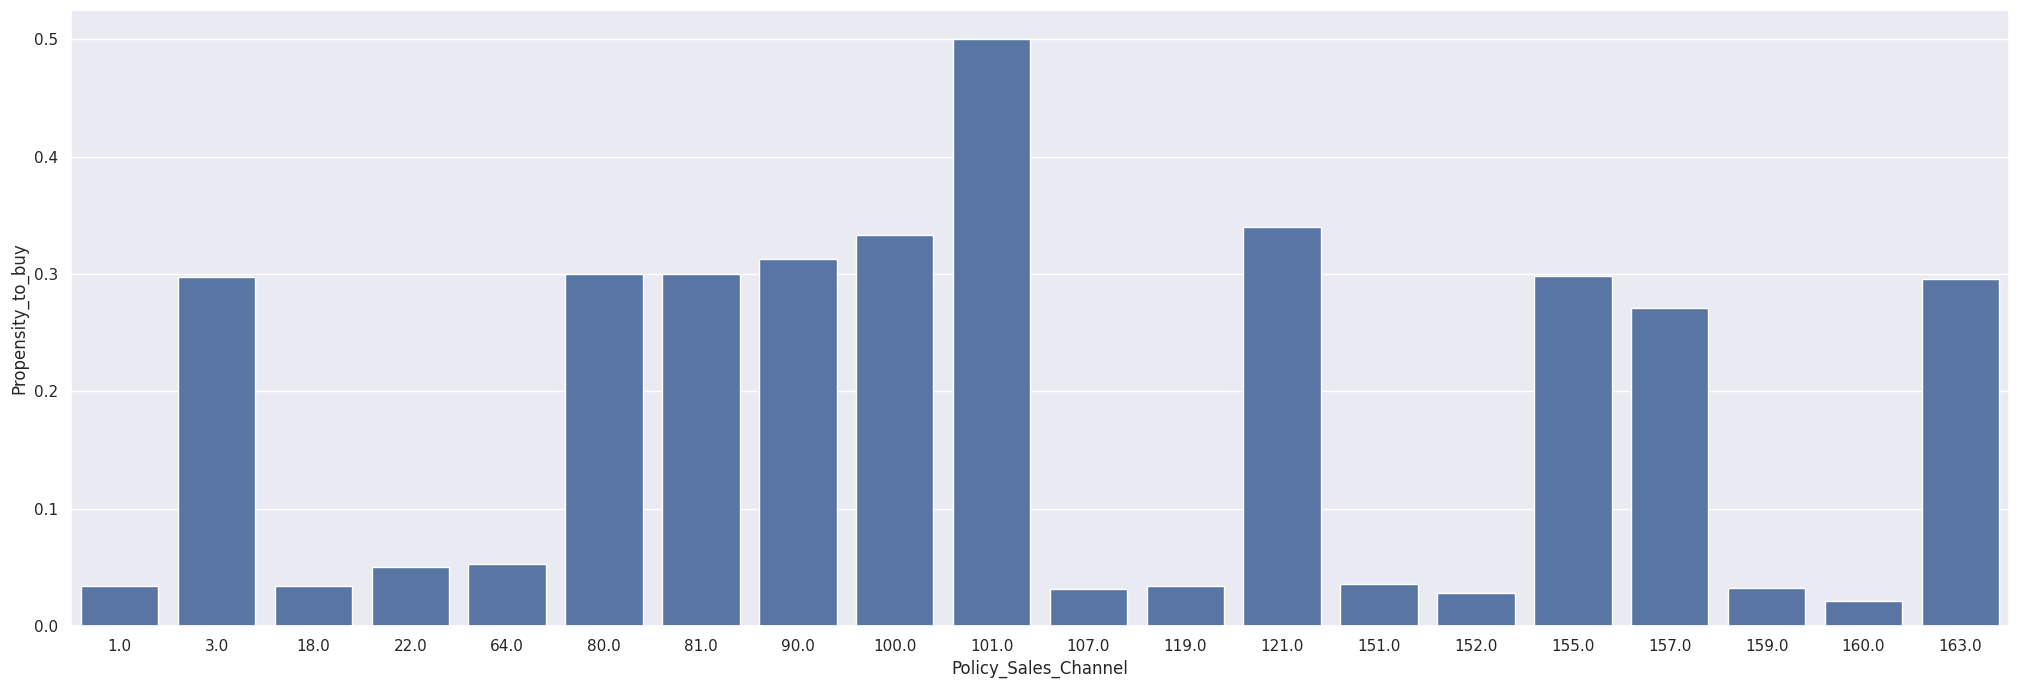

In [52]:
df_sales_channel.sort_values(by='Propensity_to_buy', ascending = False, inplace=True)
interest_sales_channel =  pd.concat([df_sales_channel.head(10), df_sales_channel.tail(10)])
interest_sales_channel
sns.barplot(data = interest_sales_channel, 
            x='Policy_Sales_Channel', 
            y='Propensity_to_buy')

### H13. Clientes sem driving license possuem menor propensão de compra

In [55]:
df_driving_license = get_frequency_table(df_1, 'Driving_License')
df_driving_license.sort_values(by='Propensity_to_buy', ascending=False)

,Driving_License,Count_Response_1,Count_Response_0,Total,Propensity_to_buy,%_sample_to_buy,%_sample_to_not_buy,%_sample_size,%_general_propensity_to_buy
1,1,29671,213702,243373,0.121916,0.999057,0.997628,0.997802,0.121763
0,0,28,508,536,0.052239,0.000943,0.002372,0.002198,0.121763


## 2.4 - Análise Multivariada

In [31]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243909 entries, 217927 to 169494
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    243909 non-null  int64  
 1   Gender                243909 non-null  object 
 2   Age                   243909 non-null  int64  
 3   Driving_License       243909 non-null  int64  
 4   Region_Code           243909 non-null  float64
 5   Previously_Insured    243909 non-null  int64  
 6   Vehicle_Age           243909 non-null  object 
 7   Vehicle_Damage        243909 non-null  object 
 8   Annual_Premium        243909 non-null  float64
 9   Policy_Sales_Channel  243909 non-null  float64
 10  Vintage               243909 non-null  int64  
 11  Response              243909 non-null  int64  
 12  faixa_etaria          243909 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 26.1+ MB


In [32]:
df_1[['Vehicle_Age','Vintage','Annual_Premium','Age','Response']].corr()

,Vehicle_Age,Vintage,Annual_Premium,Age,Response
Vehicle_Age,1.000000,-0.002110,0.040656,0.765589,0.221618
Vintage,-0.002110,1.000000,0.000443,-0.002512,-0.001060
Annual_Premium,0.040656,0.000443,1.000000,0.067026,0.023085
Age,0.765589,-0.002512,0.067026,1.000000,0.112624
Response,0.221618,-0.001060,0.023085,0.112624,1.000000


### implementing v crammer table

In [33]:
pd.crosstab(df_1.Vehicle_Age, df_1.Response)

Response,0,1
Vehicle_Age,,
0,100809,4574
1,106175,22106
2,7226,3019


In [34]:
df_1.count()

id                      243909
Gender                  243909
Age                     243909
Driving_License         243909
Region_Code             243909
Previously_Insured      243909
Vehicle_Age             243909
Vehicle_Damage          243909
Annual_Premium          243909
Policy_Sales_Channel    243909
Vintage                 243909
Response                243909
faixa_etaria            243909
dtype: int64

In [35]:
from scipy import stats 

def crammerV(col1 : str, 
             col2 : str,
             df):
    data = pd.crosstab(df[col1], df[col2])
    stat, p, dof, expected = stats.chi2_contingency(data)
    n = data.sum().sum()

    phi_2 = (stat)/n
    r = len(data)
    k = len(data.columns)

    r_til = r - ((r-1)**2)/(n-1)
    k_til = k - ((k-1)**2)/(n-1)
    phi_2_bias = ((k-1)*(r-1))/(n-1)

    phi_til = max(0, phi_2 - phi_2_bias)
    den = min([k_til -1, r_til-1])

    V = np.sqrt(phi_til/den) 

    return V

def plot_crammer(df):

    crammer = pd.DataFrame(index = df.columns, 
                           columns = df.columns)
    
    for col_interest in df.columns:
        for col in df.columns:
            #print('Calculating Crammer V for:', col_interest, 'and', col)
            v = crammerV(col1 = col_interest, 
                         col2 = col,
                         df = df)
            
            crammer.loc[col_interest, col] = v 
    
    crammer.fillna(value = np.nan, 
                   inplace = True)
    
    plt.figure(figsize=(16,6))
    sns.heatmap(
        crammer.astype(float), 
        annot = True, 
        fmt = '.2f'
    )
    return crammer 


In [36]:
cat_cols = ['Gender','Driving_License','Region_Code','Previously_Insured',
            'Vehicle_Age','Vehicle_Damage', 'Policy_Sales_Channel','faixa_etaria','Age','Response']
df_cat = df_1[cat_cols].copy()

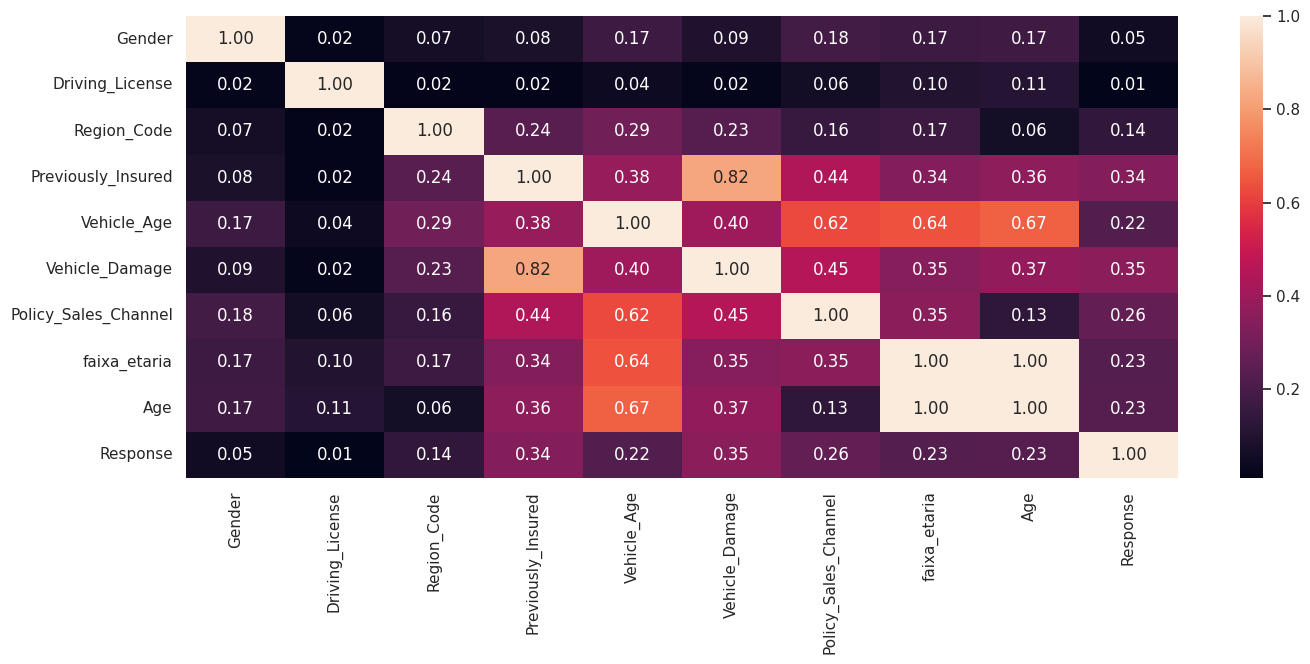

In [37]:
cr = plot_crammer(df_cat) 
